In [1]:
import os
import sys
import argparse
import numpy as np
import random

import torch
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

from clusterless.utils import NP1DataLoader, ADVIDataLoader, initialize_gmm
from clusterless.advi import ADVI
from clusterless.decoder import (
        discrete_decoder, 
        continuous_decoder, 
        sliding_window, 
        sliding_window_decoder
)
from clusterless.viz import plot_decoder_input, plot_behavior_traces

import matplotlib.pyplot as plt

In [2]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.set_default_dtype(torch.double)

seed = 666
set_seed(seed)

In [3]:
plt.rc('font', size=20)         
plt.rc('axes', titlesize=20)     
plt.rc('axes', labelsize=20) 
plt.rc('axes', linewidth=1.5)
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)   
plt.rc('legend', fontsize=20)   
plt.rc('figure', titlesize=20)

#### load data

In [4]:
np1_data_loader = NP1DataLoader(
        probe_id = 'febb430e-2d50-4f83-87a0-b5ffbb9a4943', 
        geom_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/np1_channel_map.npy', 
        ephys_path = '/mnt/3TB/yizi/danlab/Subjects/DY_009/subtract_res_wf_pcs', 
        behavior_path = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org/paper_repro_ephys_data/figure9_10/original_data'
)

Session ID: db4df448-e449-4a6f-a0e7-288711e7a75a
Probe ID: febb430e-2d50-4f83-87a0-b5ffbb9a4943 (probe00)
First trial stimulus onset time: 40.81 sec
Last trial stimulus onset time: 2252.10 sec


In [5]:
behavior_var = 'motion_energy'
brain_region = 'po'
n_time_bins = 30
if brain_region != 'all':
    is_regional = True
print(f"Decode {behavior_var} from the brain region {brain_region}:")
trials = np1_data_loader.load_spike_features(region=brain_region)
behavior = np1_data_loader.load_behaviors(behavior_var)

Decode motion_energy from the brain region po:
Found 64 channels in brain region po


In [7]:
advi_data_loader = ADVIDataLoader(
                         data = trials, 
                         behavior = behavior, 
                         n_t_bins = n_time_bins
                   )
gmm = initialize_gmm(np.concatenate(trials)[:,1:])
n_t = advi_data_loader.n_t_bins
n_c = gmm.means_.shape[0]
n_d = gmm.means_.shape[1]
print(f"Initializ GMM with {n_c} components and {n_d} spike features.")

Initializ GMM with 105 components and 5 spike features.


In [8]:
train_test_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
train_test_split.get_n_splits(trials, behavior)
train, test = next(train_test_split.split(trials, behavior)) 

In [9]:
train_data, train_ks, train_ts, test_data, test_ks, test_ts = \
advi_data_loader.split_train_test(train, test)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### encoder (advi)

In [10]:
batch_size = 1
learning_rate = 1e-3
max_iter = 30

advi = ADVI(
            n_k=batch_size, 
            n_t=n_t, 
            n_c=n_c, 
            n_d=n_d, 
            init_means=gmm.means_, 
            init_covs=gmm.covariances_
)

In [11]:
elbos = advi.train(
                s = torch.tensor(train_data[:,1:]), 
                y = torch.tensor(advi_data_loader.behavior), 
                ks = torch.tensor(train_ks), 
                ts = torch.tensor(train_ts), 
                batch_ids = list(zip(*(iter(train),) * batch_size)), 
                optim = torch.optim.Adam(advi.parameters(), lr=learning_rate), 
                max_iter=max_iter
)

iter: 1 total elbo: -72.23
iter: 2 total elbo: -66.12
iter: 3 total elbo: -62.34
iter: 4 total elbo: -58.64
iter: 5 total elbo: -56.01
iter: 6 total elbo: -53.71
iter: 7 total elbo: -51.49
iter: 8 total elbo: -49.73
iter: 9 total elbo: -48.18
iter: 10 total elbo: -46.86
iter: 11 total elbo: -45.54
iter: 12 total elbo: -44.54
iter: 13 total elbo: -43.48
iter: 14 total elbo: -42.62
iter: 15 total elbo: -41.79
iter: 16 total elbo: -40.92
iter: 17 total elbo: -40.16
iter: 18 total elbo: -39.37
iter: 19 total elbo: -38.80
iter: 20 total elbo: -38.27
iter: 21 total elbo: -37.65
iter: 22 total elbo: -37.10
iter: 23 total elbo: -36.57
iter: 24 total elbo: -36.16
iter: 25 total elbo: -35.74
iter: 26 total elbo: -35.47
iter: 27 total elbo: -35.15
iter: 28 total elbo: -34.58
iter: 29 total elbo: -34.41
iter: 30 total elbo: -33.95


#### decoder

multi-unit thresholding

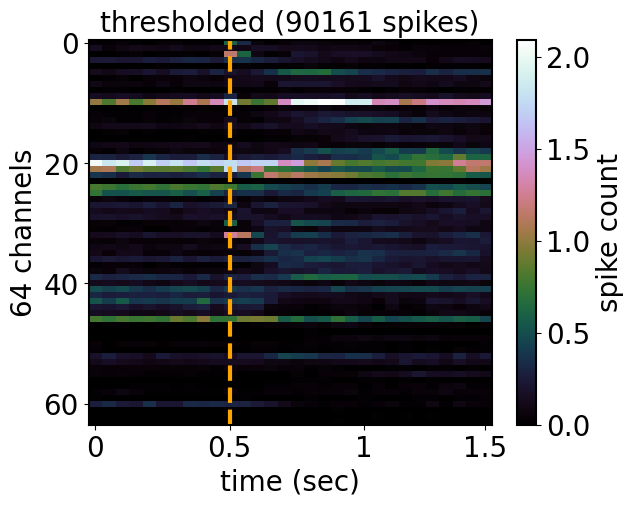

In [13]:
spike_train = np.concatenate(trials)
spike_times, spike_channels = spike_train[:,0], spike_train[:,1]
spike_labels = gmm.predict(spike_train[:,2:])
spike_probs = gmm.predict_proba(spike_train[:,2:])

thresholded = np1_data_loader.prepare_decoder_input(
    np.c_[spike_times, spike_channels],
    is_gmm=False, n_t_bins=n_t, regional=is_regional
)

plot_decoder_input(thresholded, 'thresholded', len(spike_train))

R2: 0.483, MSE: 12.089, Corr: 0.700


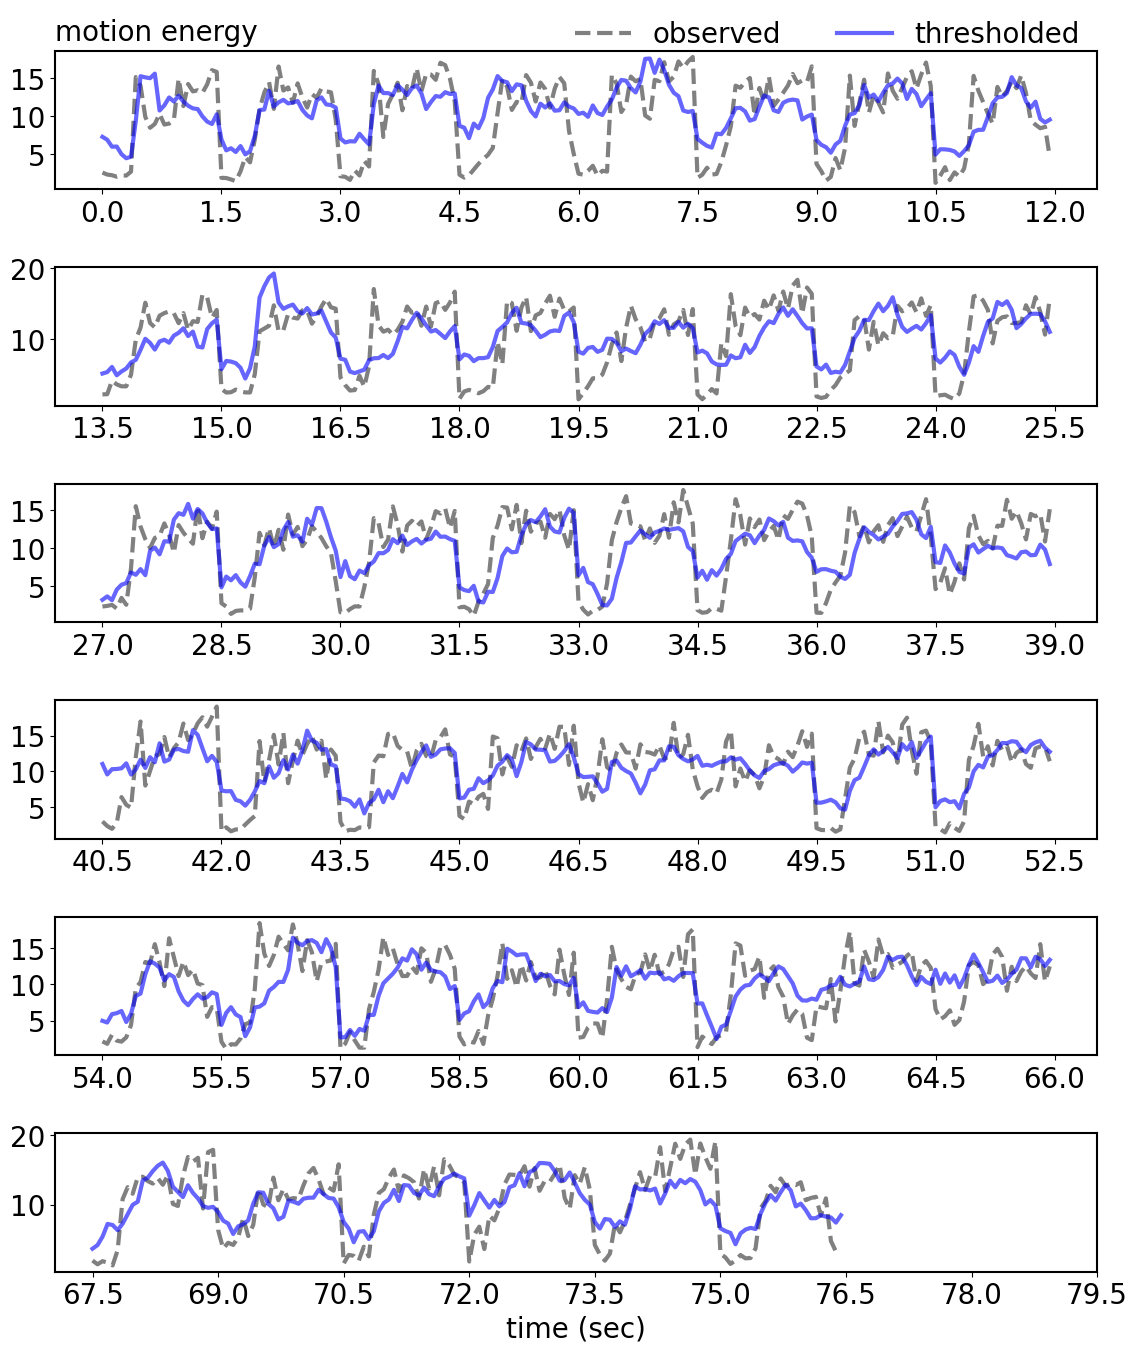

In [15]:
y_train, _, y_pred = continuous_decoder(
    thresholded, advi_data_loader.behavior, train, test
)
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
    sliding_window_decoder(
        thresholded, advi_data_loader.behavior, train, test
    )

plot_behavior_traces(window_y_test, window_y_pred, 'motion energy', 'thresholded')

ADVI + GMM

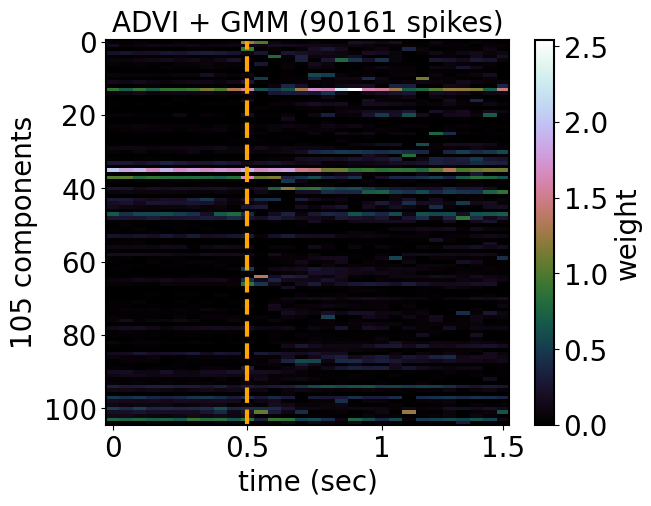

In [23]:
encoded_pis, encoded_weights = advi.encode_gmm(
            advi_data_loader.trials, train, test, y_train, y_pred
        )

plot_decoder_input(encoded_weights, 'ADVI + GMM', len(spike_train))

R2: 0.591, MSE: 9.573, Corr: 0.779


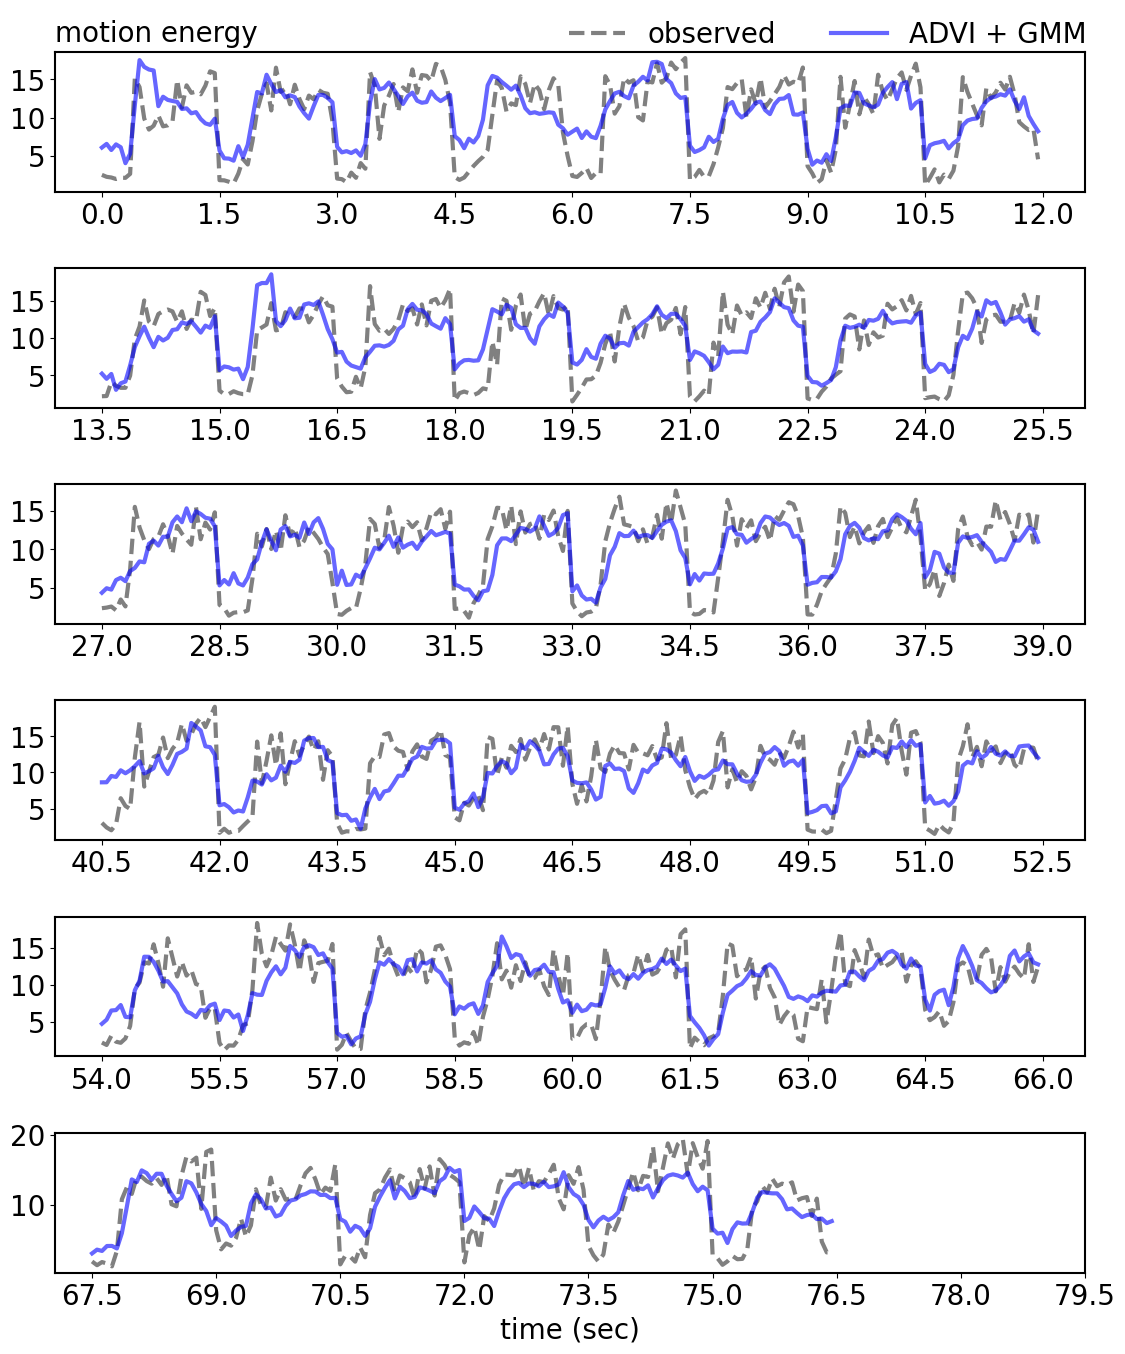

In [17]:
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
    sliding_window_decoder(
        encoded_weights, advi_data_loader.behavior, train, test
    )

plot_behavior_traces(window_y_test, window_y_pred, 'motion energy', 'ADVI + GMM')

all Kilosort units

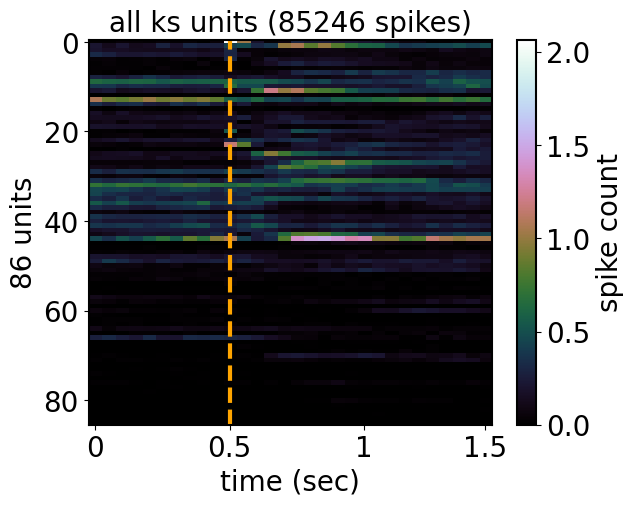

In [29]:
all_units = np.concatenate(
    np1_data_loader.load_all_units(region=brain_region)
)
ks_all = np1_data_loader.prepare_decoder_input(
    all_units, is_gmm=False, n_t_bins=n_t, regional=is_regional
)
plot_decoder_input(ks_all, 'all ks units', len(all_units))

Found 88 Kilosort units in brain region po
R2: 0.491, MSE: 11.910, Corr: 0.702


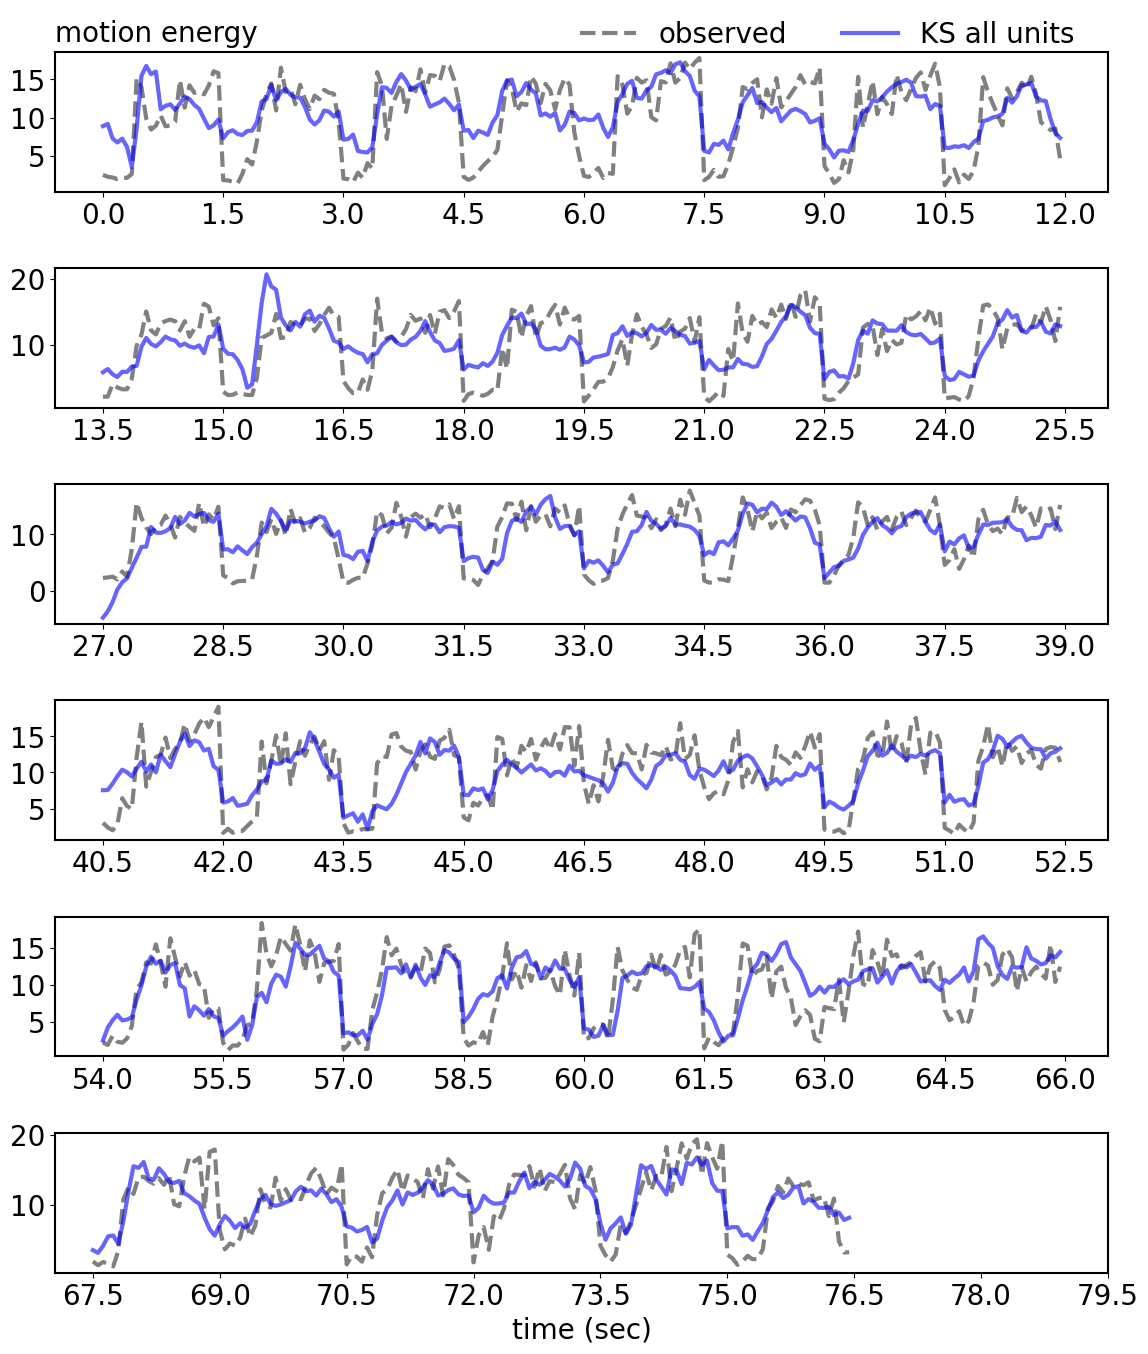

In [19]:
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
    sliding_window_decoder(
        ks_all, advi_data_loader.behavior, train, test
    )
plot_behavior_traces(window_y_test, window_y_pred, 'motion energy', 'KS all units')

good Kilosort units

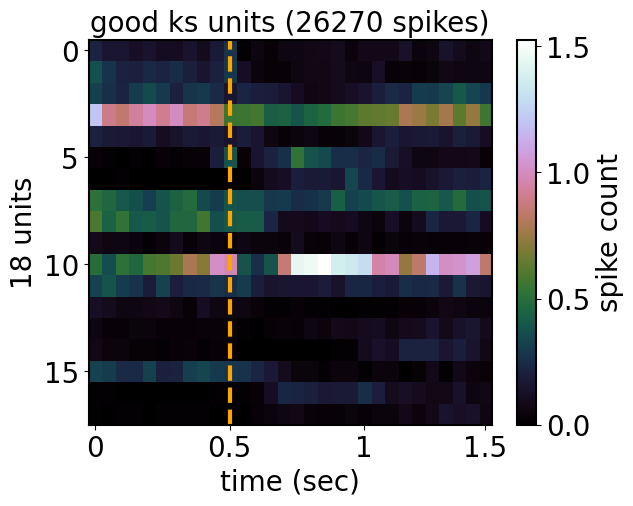

In [28]:
good_units = np.concatenate(
    np1_data_loader.load_good_units(region=brain_region)
)
ks_good = np1_data_loader.prepare_decoder_input(
    good_units, is_gmm=False, n_t_bins=n_t, regional=is_regional
)
plot_decoder_input(ks_good, 'good ks units', len(good_units))

Found 18 good units in brain region po
R2: 0.321, MSE: 15.886, Corr: 0.581


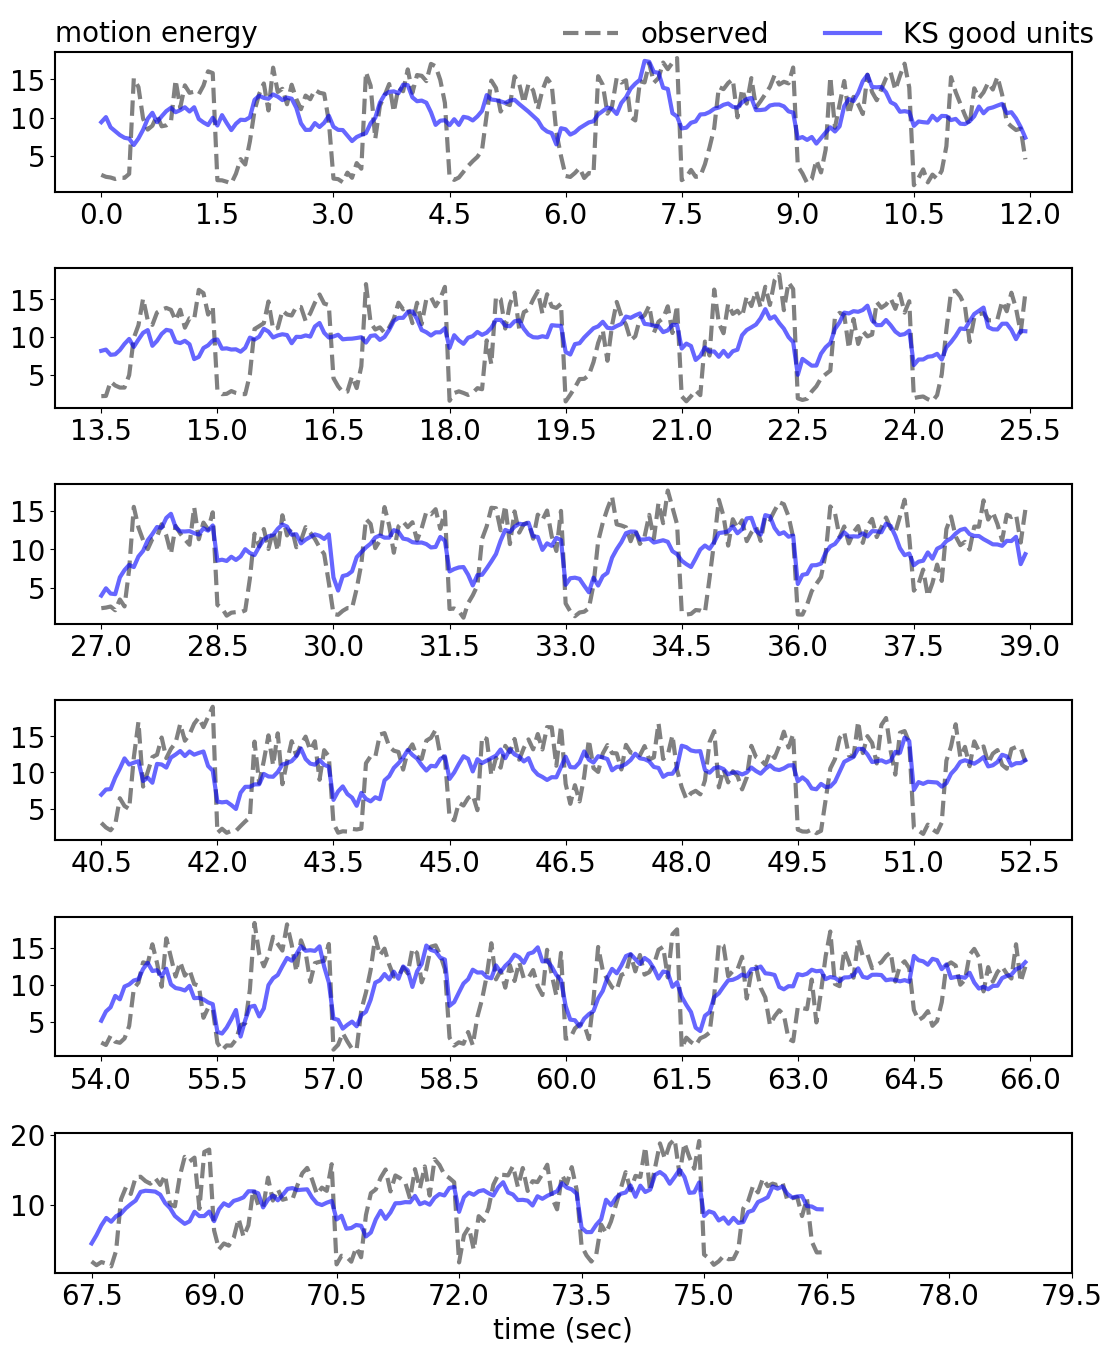

In [20]:
window_y_train, window_y_test, window_y_pred, r2, mse, corr = \
    sliding_window_decoder(
        ks_good, advi_data_loader.behavior, train, test
    )
plot_behavior_traces(window_y_test, window_y_pred, 'motion energy', 'KS good units')